# Classify global climate scenarios using the Holdridge life zone classifications

## Import neccessary packages and authenticate earth engine

In [1]:
import ee
import pandas as pd
import matplotlib.pyplot as plt

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize(project='ee-koppengeiger')

/var/folders/f0/dn4h8nt1141c2c226bgnjhg00000gn/T/ipykernel_1512/1655584342.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Import data

In [2]:
## Input Data
# Import the NASA-GDDP CMIP6 dataset for ensemble of future climate scenarios 
GDDP = ee.ImageCollection("NASA/GDDP-CMIP6")

# Import the GTOPO 30 arc second Digital Elevation Model (DEM) for elevation data, e.g. for calculating latitudinal bio temperature
demOrig = ee.Image("USGS/GTOPO30")
demReprojected = demOrig.reproject(GDDP.first().projection()) ##Reproject the DEM to GDDP crs
lapseRateScalar = -6 #degC/km 
lapseRateGlobal = demReprojected.divide(1000).multiply(lapseRateScalar) #bioTemperatre adjustments for sea level temperature using avg lapse rate

## Analysis Data
# Import World region outlines for reducing regional statistics
table = ee.FeatureCollection("USDOS/LSIB_SIMPLE/2017")

## Functions to process the data

In [3]:
#Calculate number of frost days for the whole historical record and divide by number of Years 
def snowDays(Fdays):
    return Fdays.subtract(273.15).select('tasmin').lt(0)

In [4]:
#Calculate Biotemperature Tbio and altitude adjusted BioTemperature
def BioTemperature_Altitudinal(img):
  tempMin = img.select('tasmin').subtract(273.15)
  tempMax = img.select('tasmax').subtract(273.15)
  temp = tempMin.where(tempMin.lt(0),0).add(tempMax.where(tempMax.gt(30),30)).divide(2)
  return temp

def BioTemperature_Latitudinal(img):
  tempMinLat = img.select('tasmin').subtract(273.15).subtract(lapseRateGlobal)
  tempMaxLat = img.select('tasmax').subtract(273.15).subtract(lapseRateGlobal)
  tempLat = tempMinLat.where(tempMinLat.lt(0),0).add(tempMaxLat.where(tempMaxLat.gt(30),30)).divide(2)
  return tempLat

In [5]:
def prepare_climate_inputs(climate_data, first_year, last_year, model, scenario):
    
    #Filter input climate data to desired subset
    years = ee.List.sequence(first_year,last_year,1) 
    ensemble = climate_data.filter(ee.Filter.eq('model', model)).filter(ee.Filter.eq('scenario', scenario)).filter(ee.Filter.inList('year', years)) 

    #Calculate Altitudinal and Latitudinal bio temperature
    tBioAltitudinal = ensemble.map(BioTemperature_Altitudinal)
    tBioAltitudinal = tBioAltitudinal.sum().divide(ensemble.size())

    tBioLatitudinal = ensemble.map(BioTemperature_Latitudinal)
    tBioLatitudinal = tBioLatitudinal.sum().divide(ensemble.size())

    #Calculate annual precipitation
    pAnn = ensemble.select('pr').sum().divide(years.length()).multiply(60*60*24)
    
    #Calculate potential Evaporation ratio
    PETR = tBioAltitudinal.multiply(58.93).divide(pAnn)

    #Calculate Frost Line
    Fmean = ensemble.map(snowDays)
    Fmean = Fmean.sum().divide(years.length())
    
    return pAnn,Fmean,PETR,tBioLatitudinal,tBioAltitudinal,ensemble
    

In [16]:
#Begin classification algoritm 
def holdridgeClassification(climate_data, first_year, last_year, model, scenario):

    #Process climate data
    pAnn,Fmean,PETR,tBioLatitudinal,tBioAltitudinal,ensemble = prepare_climate_inputs(climate_data, first_year, last_year, model, scenario)

    #Run holdridgeAlgorithm for altitudinal and latitudinal tBio
    HoldridgeAltitudinal = holdridgeAgorithm(pAnn,Fmean,PETR,tBioAltitudinal,ensemble)   
    HoldridgeLatitudinal = holdridgeAgorithm(pAnn,Fmean,PETR,tBioLatitudinal,ensemble)   

    #Classify triangle algorithm based on difference between altitudinal and latitudinal tBios
    HoldridgeTotitudinal = HoldridgeLatitudinal.where(HoldridgeLatitudinal.neq(
                           HoldridgeAltitudinal),HoldridgeAltitudinal.add(40)).mask(HoldridgeLatitudinal)
    
    return HoldridgeTotitudinal

## Algorithm to classify Holdridge life zones

In [17]:
def holdridgeAgorithm(pAnn,Fmean,PETR,tBio,ensemble):

    #Start with empty image
    Holdridge = ee.Image().mask(ensemble.first().select('tas'))    

    #1. Altitudinal Belt
    #1.a Tropical/Basal tBio gt 24 degC
    #1.a.i Rain Forrest Pann gt 8000 mm/year and PETR lt 0.25
    Holdridge = Holdridge.where(tBio.gte(24).And(
                         pAnn.gte(8000).Or(
                         PETR.lt(0.25))),1)
                        
    #1.a.ii wet Forrest 4000  gt Pann lt 8000 mm/year and 0.25 gt PETR lt 0.5
    Holdridge = Holdridge.where(tBio.gte(24).And(
                         pAnn.lt(8000).And(
                         PETR.gte(0.25))),2)
    
    #1.a.iii moist Forrest 2000  gt Pann lt 4000 mm/year and 0.5 gt PETR lt 1.0
    Holdridge = Holdridge.where(tBio.gte(24).And(
                         pAnn.lt(4000).And(
                         PETR.gte(0.5))),3)
    
    #1.a.iv Dry Forrest 1000  gt Pann lt 2000 mm/year and 1 gt PETR lt 2
    Holdridge = Holdridge.where(tBio.gte(24).And(
                         pAnn.lt(2000).And(
                         PETR.gte(1))),4)
    
    #1.a.v Very Dry Forrest 1000  gt Pann lt 2000 mm/year and 1 gt PETR lt 2
    Holdridge = Holdridge.where(tBio.gte(24).And(
                         pAnn.lt(1000).And(
                         PETR.gte(2))),5)
       
    #1.a.vi Thom Woodland  500  gt Pann lt 1000 mm/year and 2 gt PETR lt 4
    Holdridge = Holdridge.where(tBio.gte(24).And(
                         pAnn.lt(500).And(
                         PETR.gte(4))),6)   
                         
    #1.a.vii Desert scrub  250  gt Pann lt 500 mm/year and 8 gt PETR lt 16
    Holdridge = Holdridge.where(tBio.gte(24).And(
                         pAnn.lt(250).And(
                         PETR.gte(8))),7)
                         
    #1.a.viii Desert 500  gt Pann lt 1000 mm/year and 4 gt PETR lt 8
    Holdridge = Holdridge.where(tBio.gte(24).And(
                         pAnn.lt(125).Or(
                         PETR.gt(16))),8)
    
    
    #1.b subtropical gt 12 tBio lt 24 AND no Frost days = Fmean = 0
    #1.b. i rain forrest 
    Holdridge = Holdridge.where(tBio.gte(12).And(tBio.lt(24).And(
                         pAnn.gte(4000).Or(
                         PETR.lt(0.25).And(
                         Fmean.eq(0))))),9)
    
    #1.b. ii wet forrest 
    Holdridge = Holdridge.where(tBio.gte(12).And(tBio.lt(24).And(
                         pAnn.lt(4000).And(
                         PETR.gte(0.25).And(
                         Fmean.eq(0))))),10)   
                         
    #1.b. iii moist forrest 
    Holdridge = Holdridge.where(tBio.gte(12).And(tBio.lt(24).And(
                         pAnn.lt(2000).And(
                         PETR.gte(0.5).And(
                         Fmean.eq(0))))),11)   
    
    #1.b. iv dry forrest
    Holdridge = Holdridge.where(tBio.gte(12).And(tBio.lt(24).And(
                         pAnn.lt(1000).And(
                         PETR.gte(1).And(
                         Fmean.eq(0))))),12)   
    
    #1.b. v Thom Woodland
    Holdridge = Holdridge.where(tBio.gte(12).And(tBio.lt(24).And(
                         pAnn.lt(500).And(
                         PETR.gte(2).And(
                         Fmean.eq(0))))),13)     
                         
    #1.b. vi Desert Scrub
    Holdridge = Holdridge.where(tBio.gte(12).And(tBio.lt(24).And(
                         pAnn.lt(250).And(
                         PETR.gte(4).And(
                         Fmean.eq(0))))),14)    
    
    #1.b. vii Desert 
    Holdridge = Holdridge.where(tBio.gte(12).And(tBio.lt(24).And(
                         pAnn.lt(125).Or(
                         PETR.gt(8).And(
                         Fmean.eq(0))))),15)    
                         
    #1.c warm temperate gt 12 tBio lt 24 AND Frost days gt 0
    #1.c. i rain forrest 
    Holdridge = Holdridge.where(tBio.gte(12).And(tBio.lt(24).And(
                         pAnn.gte(4000).Or(
                         PETR.lt(0.25).And(
                         Fmean.gt(0))))),16)
                         
    #1.c. ii wet forrest 
    Holdridge = Holdridge.where(tBio.gte(12).And(tBio.lt(24).And(
                         pAnn.lt(4000).And(
                         PETR.gte(0.25).And(
                         Fmean.gt(0))))),17)   
                         
    #1.c. iii moist forrest 
    Holdridge = Holdridge.where(tBio.gte(12).And(tBio.lt(24).And(
                         pAnn.lt(2000).And(
                         PETR.gte(0.5).And(
                         Fmean.gt(0))))),18)   
    
    #1.c. iv dry forrest
    Holdridge = Holdridge.where(tBio.gte(12).And(tBio.lt(24).And(
                         pAnn.lt(1000).And(
                         PETR.gte(1).And(
                         Fmean.gt(0))))),19)   
    
    #1.c. v Thom Woodland
    Holdridge = Holdridge.where(tBio.gte(12).And(tBio.lt(24).And(
                         pAnn.lt(500).And(
                         PETR.gte(2).And(
                         Fmean.gt(0))))),20)     
                         
    #1.c. vi Desert Scrub
    Holdridge = Holdridge.where(tBio.gte(12).And(tBio.lt(24).And(
                         pAnn.lt(250).And(
                         PETR.gte(4).And(
                         Fmean.gt(0))))),21)    
    
    #1.c. vii Desert 
    Holdridge = Holdridge.where(tBio.gte(12).And(tBio.lt(24).And(
                         pAnn.lt(125).Or(
                         PETR.gt(8).And(
                         Fmean.gt(0))))),22)  
                         
    #1.d Cool temperate gt 6 tBio lt 12  AND Frost days gt 0
    #1.d. i rain forrest 
    Holdridge = Holdridge.where(tBio.gte(6).And(tBio.lt(12).And(
                         PETR.lt(0.25).Or(
                         pAnn.gt(2000)))),23)
    
    #1.d. ii wet forrest 
    Holdridge = Holdridge.where(tBio.gte(6).And(tBio.lt(12).And(
                         pAnn.lt(2000).And(
                         PETR.gte(0.25)))),24) 
                         
    #1.d. iii moist forrest 
    Holdridge = Holdridge.where(tBio.gte(6).And(tBio.lt(12).And(
                         pAnn.lt(1000).And(
                         PETR.gte(0.5)))),25)
    
    #1.d. iv steppe 
    Holdridge = Holdridge.where(tBio.gte(6).And(tBio.lt(12).And(
                         pAnn.lt(500).And(
                         PETR.gte(1)))),26)   
    
    #1.d. v Desert Scrub 
    Holdridge = Holdridge.where(tBio.gte(6).And(tBio.lt(12).And(
                         pAnn.lt(250).And(
                         PETR.gte(2)))),27)       
    
    #1.d. vi Desert  
    Holdridge = Holdridge.where(tBio.gte(6).And(tBio.lt(12).And(
                         pAnn.lt(125).Or(
                         PETR.gte(4)))),28)    
                         
    #1.e Boreal gt 3 tBio lt 6  
    #1.e. i rain forrest 
    Holdridge = Holdridge.where(tBio.gte(3).And(tBio.lt(6).And(
                         PETR.lte(0.25).Or(
                         pAnn.gt(1000)))),29)
    
    #1.e. ii wet forrest 
    Holdridge = Holdridge.where(tBio.gte(3).And(tBio.lt(6).And(
                         pAnn.lt(1000).And(
                         PETR.gt(0.25)))),30)
                         
    #1.e. iii moist forrest 
    Holdridge = Holdridge.where(tBio.gte(3).And(tBio.lt(6).And(
                         pAnn.lt(500).And(
                         PETR.gte(0.5)))),31)                      
    
    #1.e. iv dry scrub 
    Holdridge = Holdridge.where(tBio.gte(3).And(tBio.lt(6).And(
                         pAnn.lt(250).And(
                         PETR.gte(1)))),32) 
     
    #1.e. v Desert 
    Holdridge = Holdridge.where(tBio.gte(3).And(tBio.lt(6).And(
                         pAnn.lt(125).Or(
                         PETR.gt(2)))),33)                     
    
    #1.f subPolar gt 1.5 tBio lt 3  
    #1.f. i Rain Tundra 
    Holdridge = Holdridge.where(tBio.gte(1.5).And(tBio.lt(3)).And(
                         pAnn.gte(500).Or(
                         PETR.lt(0.25))),34)
    
    #1.f. ii Wet Tundra 
    Holdridge = Holdridge.where(tBio.gte(1.5).And(tBio.lt(3)).And(
                         pAnn.lt(500).And(
                         PETR.gte(0.25))),35)
    
    #1.f. iii Moist Tundra 
    Holdridge = Holdridge.where(tBio.gte(1.5).And(tBio.lt(3)).And(
                         pAnn.lte(250).And(
                         PETR.gte(0.5))),36)                     
    
    #1.f.iv Dry Tundra 
    Holdridge = Holdridge.where(tBio.gte(1.5).And(tBio.lt(3)).And(
                         pAnn.lt(125).Or(
                         PETR.gt(2))),37)                     
    
    
    #1.g Polar tBio lt 1.5
    #1.g.i Rain Tundra 
    Holdridge = Holdridge.where(tBio.lt(1.5).And(
                         PETR.lt(0.25).Or(
                         pAnn.gt(250))),38)
    
    #1.g.ii Wet Tundra 
    Holdridge = Holdridge.where(tBio.lt(1.5).And(
                         pAnn.gte(125).And(pAnn.lte(250).And(
                         PETR.gte(0.25).And(PETR.lte(0.5))))),39)
    
    #1.g.iii Dry Tundra 
    Holdridge = Holdridge.where(tBio.lt(1.5).And(
                         pAnn.lt(125).Or(
                         PETR.gt(0.5))),40)
    
    return Holdridge

In [18]:
def regionalStats(region):
    
    #Calculate regional histogram of classifications
    regional_histogram_reducer = Holdridge.reduceRegions(
      collection = region,
      reducer = ee.Reducer.fixedHistogram(min = 1, max = 81, steps = 80, cumulative = False),scale = 20000)
    
    #extract histogram
    fc_client = regional_histogram_reducer.getInfo()
    regional_histogram = fc_client['features'][0]['properties']['histogram']    
    
    df = pd.DataFrame(regional_histogram, columns = ['holdridgeClass', 'Number']) 

    return df

# Run the holdridge algorithm 

In [22]:
first_year = 1950
last_year = 2010
Holdridge = holdridgeClassification(climate_data = GDDP,first_year = first_year,last_year = last_year, model='EC-Earth3',scenario = 'historical')

## Reduce Regional Data

,holdridgeClass,Number,Frequency
0,1,0.000000,0.000000
1,2,0.000000,0.000000
2,3,0.000000,0.000000
3,4,0.000000,0.000000
4,5,0.000000,0.000000
...,...,...,...
75,76,0.000000,0.000000
76,77,0.000000,0.000000
77,78,1436.407843,3.256536
78,79,0.000000,0.000000


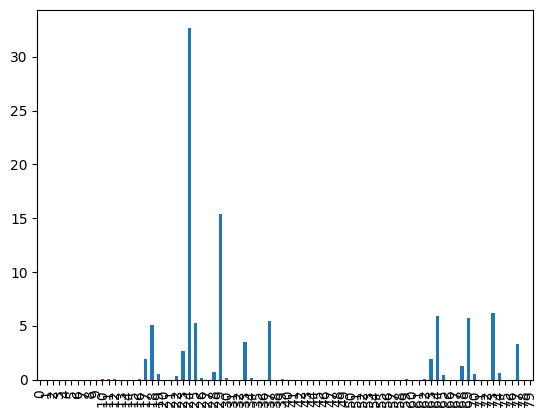

In [23]:
#Select region
region = table.filter(ee.Filter.eq('wld_rgn','Europe')).geometry()
df = regionalStats(region)

df['Number'].sum()
df['Frequency'] = df['Number'].divide(df['Number'].sum())*100
df['Frequency'].plot(kind = 'bar')
df.to_csv('~/Data/climateClassifications/classTest.csv')
df

In [21]:
from IPython.display import Image

holdridgePalette = ['#ea9a3d', '#447768', '#2d3aee', '#fe3a7a', '#cab2b3', '#6e219d', '#ccbddb', '#1e485e', '#7f2f4d', '#8378ee', '#83bc03', '#79fc77', '#9d4bae', '#2de630', '#b20a12', '#d518a5', '#5d59c1', '#b0d74d', '#ab2333', '#1ecbed', '#2d5c30', '#f02d58', '#b4596f', '#bd440b', '#486fa6', '#566ad0', '#386de9', '#cf71a1', '#b4b09c', '#1959e4', '#18f164', '#fdd36f', '#39fc5b', '#4ccce6', '#c26a2c', '#69cc66', '#2b84fc', '#0ea36b', '#f7e771', '#adc868', '#cf331b', '#0d7cc2', '#d4c424', '#b1df18', '#7c2093', '#0bb0db', '#3163ff', '#5cedfc', '#6b33e0', '#7b3230', '#85d6f9', '#09bbad', '#ce7d3b', '#951cf7', '#e46c84', '#088b9e', '#277b55', '#4e5c49', '#0a9fdd', '#99c553', '#6096a8', '#810953', '#b658f1', '#a6bd70', '#83a597', '#5a5c6e', '#e44a99', '#987eab', '#5a469c', '#d7b32b', '#81ccf9', '#1dfb75', '#394b9f', '#d25830', '#1bb349', '#6ec219', '#e03d9c', '#b5f9e6', '#af7bf3', '#458e65', '#8c298c', '#4273ee', '#2d42d5', '#0f6626', '#d14edb', '#fe6360', '#41f067', '#f87226', '#91177c', '#dcb2e2', '#374f4f', '#b42f90', '#989cf4', '#6c8e80', '#badd1d', '#846b5b', '#c271be', '#9f9923', '#9ed459', '#fa4f67']

# Create a URL to the styled image 
url = Holdridge.getThumbUrl({
    'min': 1, 'max': 80 , 'dimensions': 2048, 
    'palette': holdridgePalette })
print(url)

# Display the thumbnail 
print('\nPlease wait while the thumbnail loads, it may take a moment...')
Image(url=url)

https://earthengine.googleapis.com/v1/projects/ee-koppengeiger/thumbnails/34796283ac3ae296fa74a0782f81a96e-51c5fc8b114db2bf23f7f50275caf102:getPixels

Please wait while the thumbnail loads, it may take a moment...
